In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

dir = 'query_performance_plots'
os.makedirs(dir, exist_ok=True)
df = pd.read_csv('results.csv')
# df_indexed = pd.read_csv('indexed.csv')
# df_non_indexed = pd.read_csv('not_indexed.csv')

# df_indexed['Indexed'] = True
# df_non_indexed['Indexed'] = False
# df_combined = pd.concat([df_indexed, df_non_indexed])
# df_combined['QueryType'] = df_combined['QueryName'].str.extract(r'([^\.]+)')

# df_combined = df_combined.drop(['QueryName', 'Parameters', 'ResultCount', 'Success', 'ErrorMessage'], axis=1)
# df_combined.to_csv("results.csv", index=False)


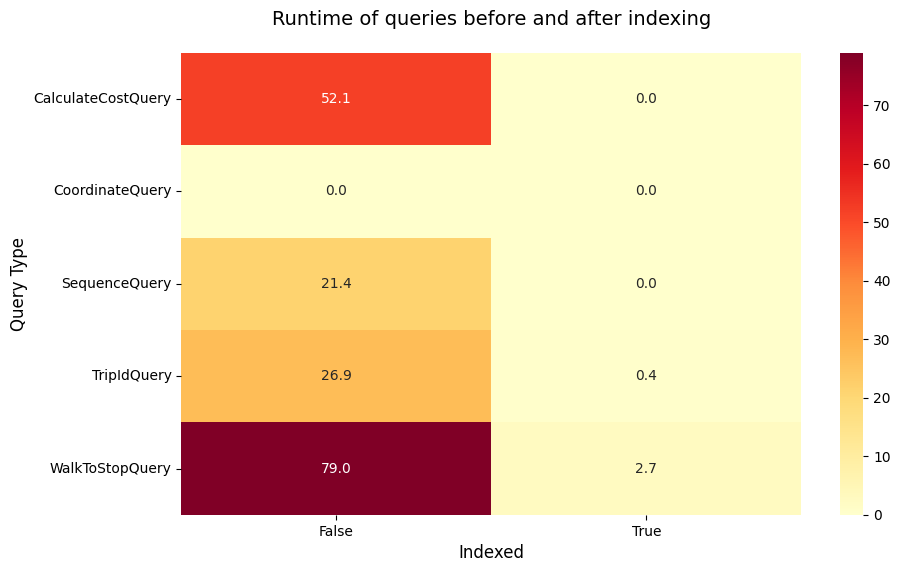

In [51]:
heatmap_data = df.groupby(['QueryType', 'Indexed'])['ExecutionTimeMs'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Runtime of queries before and after indexing', pad=20, fontsize=14)
plt.xlabel('Indexed', fontsize=12)
plt.ylabel('Query Type', fontsize=12)
plt.savefig(dir + '/average execution time.png', dpi=600)
plt.show()

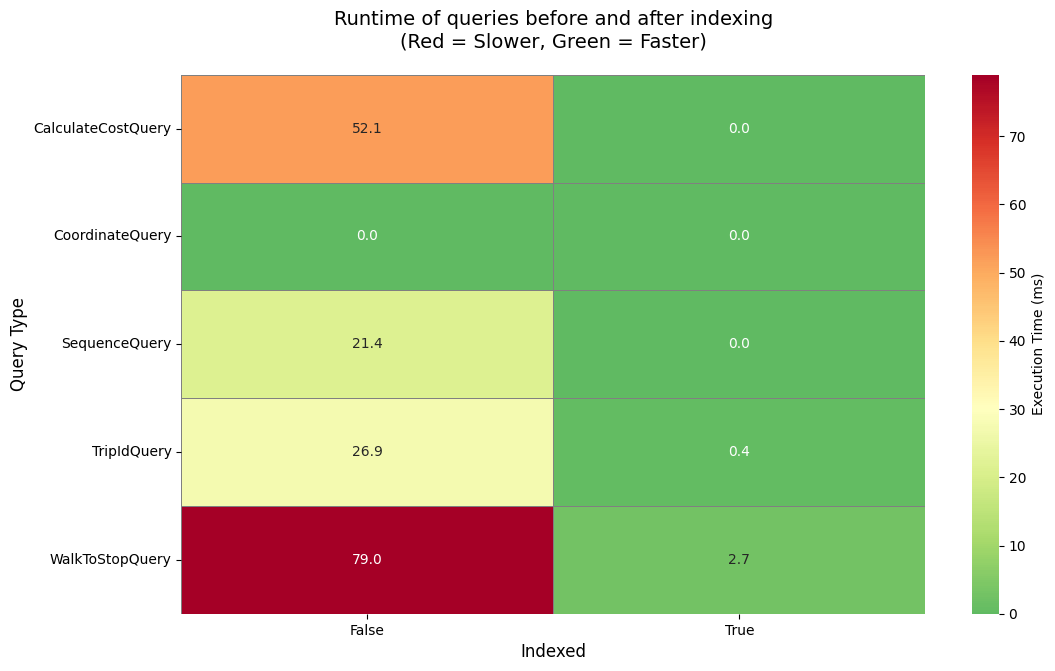

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn_r',
    center=30,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Execution Time (ms)'}
)

plt.title('Runtime of queries before and after indexing\n(Red = Slower, Green = Faster)', pad=20, fontsize=14)
plt.xlabel('Indexed', fontsize=12)
plt.ylabel('Query Type', fontsize=12)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)

plt.savefig(dir + 'average_execution_time_red_green.png', dpi=600, bbox_inches='tight')

plt.show()

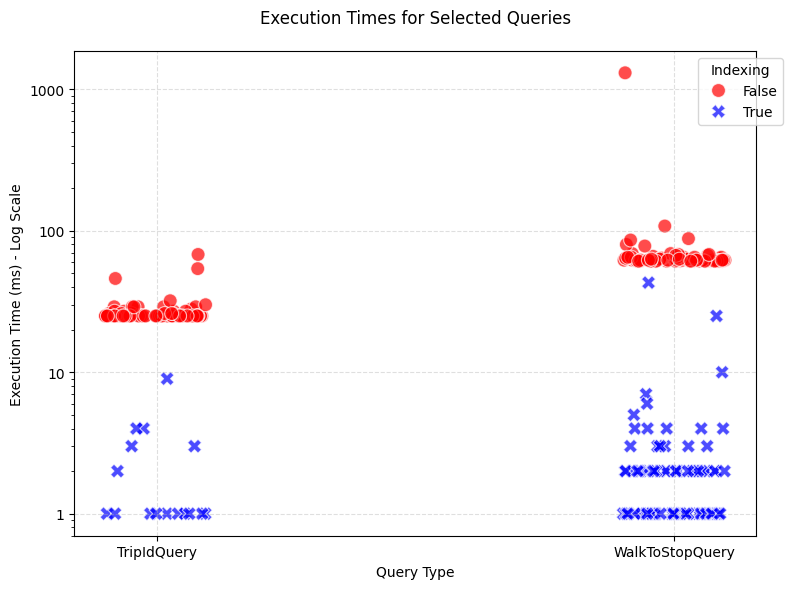

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df[df['QueryType'].isin(['TripIdQuery', 'WalkToStopQuery'])].copy()

query_map = {'TripIdQuery': 0, 'WalkToStopQuery': 1}
df_filtered['QueryPos'] = df_filtered['QueryType'].map(query_map)

np.random.seed(42)
df_filtered['QueryPosJittered'] = df_filtered['QueryPos'] + np.random.uniform(-0.1, 0.1, size=len(df_filtered))

plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x='QueryPosJittered',
    y='ExecutionTimeMs',
    hue='Indexed',
    style='Indexed',
    data=df_filtered,
    s=100,
    alpha=0.7,
    palette={True: 'blue', False: 'red'}
)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plt.xticks([0, 1], ['TripIdQuery', 'WalkToStopQuery'])
plt.xlabel('Query Type')
plt.ylabel('Execution Time (ms) - Log Scale')
plt.title('Execution Times for Selected Queries', pad=20)

# Customize legend
legend = plt.legend(title='Indexing', bbox_to_anchor=(1.05, 1))
plt.grid(True, which='major', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(dir + "/scatter.png", dpi=600)
plt.show()


Average Execution Time (ms) and Improvement per Query Type:
                    Not_Indexed   Indexed  Improvement (%)
CalculateCostQuery    52.066667  0.000000       100.000000
CoordinateQuery        0.000000  0.000000         0.000000
SequenceQuery         21.355556  0.000000       100.000000
TripIdQuery           26.897436  0.448718        98.331745
WalkToStopQuery       79.011905  2.738095        96.534579
OVERALL               36.481818  0.803030        97.798821


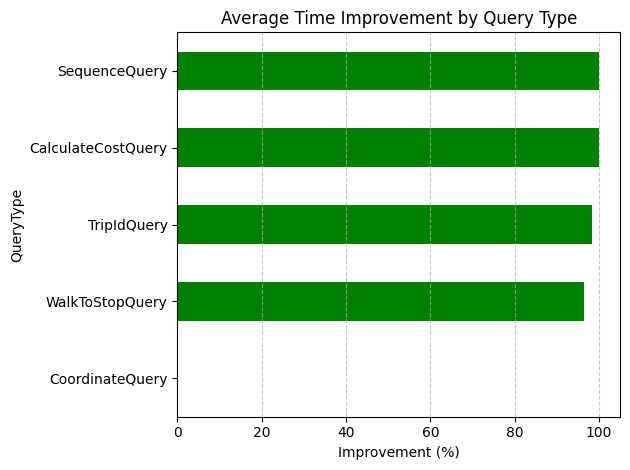

,Not_Indexed,Indexed,Improvement (%)
CalculateCostQuery,52.07 ms,0.00 ms,100.0 %
CoordinateQuery,0.00 ms,0.00 ms,0.0 %
SequenceQuery,21.36 ms,0.00 ms,100.0 %
TripIdQuery,26.90 ms,0.45 ms,98.3 %
WalkToStopQuery,79.01 ms,2.74 ms,96.5 %
OVERALL,36.48 ms,0.80 ms,97.8 %


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

grouped = df.groupby(['QueryType', 'Indexed'])['ExecutionTimeMs'].mean().unstack()
grouped.columns = ['Not_Indexed', 'Indexed']
grouped['Improvement (%)'] = ((grouped['Not_Indexed'] - grouped['Indexed']) / grouped['Not_Indexed']) * 100
grouped['Improvement (%)'] = grouped['Improvement (%)'].fillna(0)

overall = df.groupby('Indexed')['ExecutionTimeMs'].mean()
overall_improvement = ((overall[False] - overall[True]) / overall[False]) * 100 if overall[False] > 0 else 0
overall_row = pd.DataFrame({
    'Not_Indexed': [overall[False]],
    'Indexed': [overall[True]],
    'Improvement (%)': [overall_improvement]
}, index=['OVERALL'])

grouped_with_overall = pd.concat([grouped, overall_row])
print("Average Execution Time (ms) and Improvement per Query Type:")
print(grouped_with_overall)
grouped['Improvement (%)'].sort_values().plot(kind='barh', color='green')
plt.title("Average Time Improvement by Query Type")
plt.xlabel("Improvement (%)")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

styled_table = grouped_with_overall.style \
    .background_gradient(subset=["Indexed", "Not_Indexed", "Improvement (%)"], cmap="Greens") \
    .format({
    "Indexed": "{:.2f} ms",
    "Not_Indexed": "{:.2f} ms",
    "Improvement (%)": "{:.1f} %"
}) \
    .set_caption("Average runtime and improvement after indexing")

styled_table
styled_table.to_html("query_performance_styled.html")